# Price Prediction of used cars - Pakwheels

-----------


## Import Libraries

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')



## Load Dataset

In [69]:
df = pd.read_csv('D:/DS Bootcamp/Machine Learning/Used cars Price prediction/Used-Cars-Price-Prediction-Pakwheels/Pakwheels_used_cars.csv')
df.head()

,title,location,model_year,fuel_type,transmission,km_driven,registered_in,color,assembly,engine_capacity,body_type,last_updated,price,url
0,Suzuki Mehran 2003,Multan Punjab,2003.0,Petrol,Manual,"170,000 km",Lahore,White,Local,800 cc,NaN,"May 07, 2025",PKR 5.8 Lakh,https://www.pakwheels.com/used-cars/suzuki-meh...
1,Mitsubishi Lancer GLX Automatic 1.6 2006,Lahore Punjab,2006.0,Petrol,Automatic,"119,080 km",Islamabad,Labrador Black Pearl,Imported,1600 cc,Sedan,"Apr 29, 2025",PKR 25 Lakh,https://www.pakwheels.com/used-cars/mitsubishi...
2,Suzuki Wagon R Stingray X 2013,"Abbot Road, Lahore Punjab",2013.0,Petrol,Automatic,"87,000 km",Punjab,Black,Imported,660 cc,Hatchback,"Apr 29, 2025",PKR 26.5 Lakh,https://www.pakwheels.com/used-cars/suzuki-wag...
3,Toyota Land Cruiser ZX 2019,Lahore Punjab,2019.0,Petrol,Automatic,"30,000 km",Un-Registered,White Pearl Crystal Shine,Imported,4600 cc,SUV,"Apr 28, 2025",PKR 4.63 crore,https://www.pakwheels.com/used-cars/toyota-lan...
4,Suzuki Alto VXL AGS 2021,"Rehmania Town, Faisalabad Punjab",2021.0,Petrol,Automatic,"15,800 km",Punjab,Silver,Local,660 cc,Hatchback,"Apr 30, 2025",PKR 27.7 Lakh,https://www.pakwheels.com/used-cars/suzuki-alt...


------

## Data Preprocessing

### Handle Data inconsisties

From title column extract the brand name and store it to a new column called brand

In [70]:
df.insert(0, 'brand', df['title'].str.split().str[0])

Rename the title to model_name

In [71]:
df.rename(columns={'title':'model_name'},inplace=True)

Extract from location all the provinces and stored in new column province

In [72]:
df.insert(2, 'province', df['location'].str.split().str[-1])

Correct the dtype of model_year into int.

In [73]:
df['model_year'] = pd.to_numeric(df['model_year'], errors='coerce')

Replace comma and km from the km_driven column

In [74]:
df['km_driven'] = df['km_driven'].replace({',': '', ' km': ''}, regex=True).str.strip()

Correct the dtype of km_driven into int

In [75]:
df['km_driven'] = pd.to_numeric(df['km_driven'], errors='coerce')

Add a new column of engine size in numeric

In [76]:
df.insert(12, 'engine_power', df['engine_capacity'].str.split().str[0].astype('float'))

Remove cars with engine capacity less than 600 cc, as we are predicting prices of used cars

In [77]:
df['unit'] = df['engine_capacity'].str.extract(r'([a-zA-Z]+)')

df = df[~((df['unit'].str.lower() == 'cc') & (df['engine_power'] < 600))]
df.reset_index(drop=True, inplace=True)

Remove the unit column

In [78]:
df.drop(columns=['unit'], inplace=True)

Correct the last_updated column type into date format

In [79]:
df['last_updated'] = pd.to_datetime(df['last_updated'], format='%b %d, %Y', errors='coerce')

We have 180 rows where the price is listed as "on call for price." Since price is our target column, including any incorrect or missing information could negatively impact the performance of our model. Therefore, we have decided to remove these rows to ensure the quality and accuracy of the data.

In [80]:
df = df[df['price'] != 'Call for price']

Remove PKR from the price column

In [81]:
df['price'] = df['price'].str.replace('PKR', '', regex=True).str.strip()

Calculate the lacs and crores values and convert into float

In [82]:
def convert_price(value):
    if isinstance(value, (float, int)):
        return value  

    value = value.strip().lower()
    if 'crore' in value:
        num = value.replace('crore', '').strip()  
        try:
            return float(num) * 10_000_000
        except ValueError:
            return None
    elif 'lakh' in value:
        num = value.replace('lakh', '').strip() 
        try:
            return float(num) * 100_000  
        except ValueError:
            return None  
    try:
        return float(value)
    except ValueError:
        return None 

df['price'] = df['price'].apply(convert_price)

Drop the Url column bcz it didn't help in prediction

In [83]:
df.drop(columns=['url'], inplace=True)

We have too many unique colors, which could negatively affect our model. Therefore, I've decided to convert the colors into base colors for better generalization and model performance.

In [84]:
df['color'].nunique()

433

In [85]:
base_colors = ['white', 'silver', 'black', 'grey', 'blue', 'green', 'red', 'orange', 'pink', 'purple', 'indigo', 'brown', 'turquoise', 'titanium', 'metallic', 'maroon'
               'gold', 'bronze', 'beige', 'navy', 'burgundy','magneta', 'unlisted']

def map_to_base_color(color):
    if pd.isna(color):
        return 'others'
    color = color.lower()
    for base_color in base_colors:
        if base_color in color:
            return base_color
    return 'others'

df['color'] = df['color'].apply(map_to_base_color)

from 430 to 22 color that reduces the model complexity

In [86]:
df['color'].nunique()

22

------------

### Handle Missing Values

In [87]:
(df.isnull().sum() / len(df)* 100).sort_values(ascending = False)

body_type          10.627675
model_year         10.291420
brand               0.152843
model_name          0.152843
province            0.152843
location            0.152843
fuel_type           0.152843
transmission        0.152843
km_driven           0.152843
registered_in       0.152843
assembly            0.152843
engine_capacity     0.152843
engine_power        0.152843
last_updated        0.152843
price               0.152843
color               0.000000
dtype: float64

We have around 10% missing values in body type and 10% missing values in model year

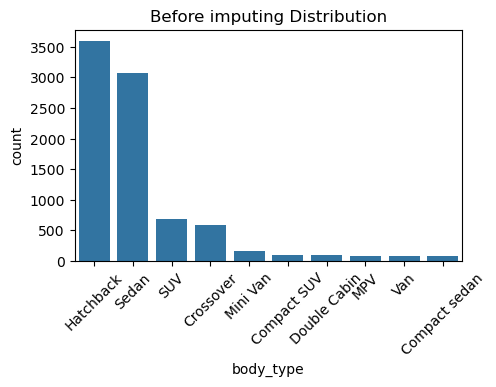

In [88]:
plt.figure(figsize=(5, 3))
plt.subplot(1, 1, 1)

top_10 = df['body_type'].value_counts().nlargest(10).index.tolist()
sns.countplot(data=df, x='body_type', order=top_10)
plt.title('Before imputing Distribution')
plt.xticks(rotation=45)
plt.show()

In [89]:
df['body_type'].fillna(df['body_type'].mode()[0],inplace=True)

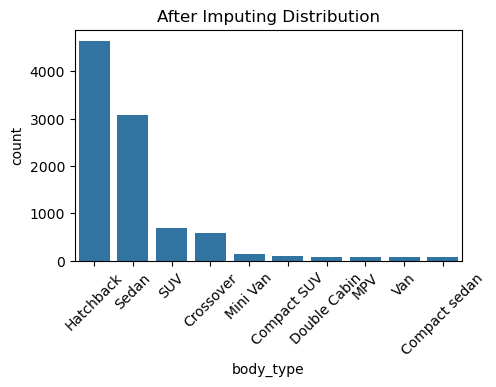

In [90]:
plt.figure(figsize=(5, 3))
plt.subplot(1, 1, 1)

top_10 = df['body_type'].value_counts().nlargest(10).index.tolist()
sns.countplot(data=df, x='body_type', order=top_10)
plt.title('After Imputing Distribution')
plt.xticks(rotation=45)
plt.show()

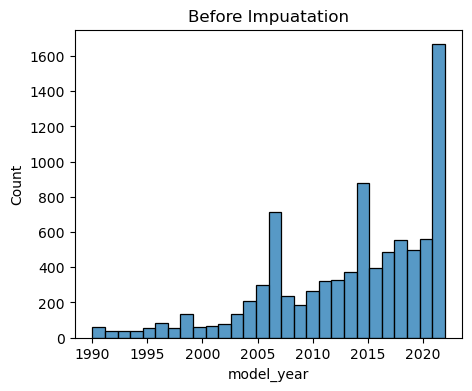

In [91]:
plt.figure(figsize=(5, 4))
plt.subplot(1, 1, 1)
sns.histplot(data=df, x='model_year')
plt.title('Before Impuatation')
plt.show()

In model_name model_year also written it, so we extarct model year from that and put it to the missing value of that particular row

In [92]:
df[df['model_year'].isna()]['model_name'].value_counts().head()

model_name
Suzuki Alto VXR 2024        45
Suzuki Alto VXR 2023        31
Haval H6 HEV 2024           28
Suzuki Alto VXL AGS 2023    21
Suzuki Alto VXL AGS 2024    20
Name: count, dtype: int64

In [93]:
import re

def extract_year_from_name(name):
    match = re.search(r'(19|20)\d{2}', str(name))
    if match:
        return int(match.group())
    return None

df.loc[df['model_year'].isna(), 'model_year'] = df[df['model_year'].isna()]['model_name'].apply(extract_year_from_name)

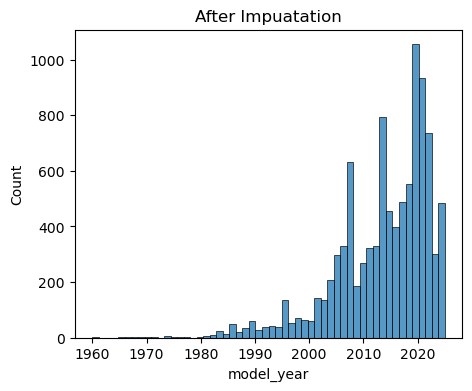

In [94]:
plt.figure(figsize=(5, 4))
plt.subplot(1, 1, 1)
sns.histplot(data=df, x='model_year')
plt.title('After Impuatation')
plt.show()

Remaining 0.15% missing values are all Missing rows,so we remove those rows from the dataset

In [95]:
df.dropna(inplace=True)

In [96]:
(df.isnull().sum() / len(df)* 100).sort_values(ascending = False)

brand              0.0
model_name         0.0
province           0.0
location           0.0
model_year         0.0
fuel_type          0.0
transmission       0.0
km_driven          0.0
registered_in      0.0
color              0.0
assembly           0.0
engine_capacity    0.0
engine_power       0.0
body_type          0.0
last_updated       0.0
price              0.0
dtype: float64

From model_name remove the model yr bcz we already have year of model in dataset

In [97]:
df['model_name'] = df['model_name'].str.replace(r'\b\d{4}$', '', regex=True).str.strip()

-------------

### Handle Duplicates

In [98]:
df[df.duplicated(keep=False)]

,brand,model_name,province,location,model_year,fuel_type,transmission,km_driven,registered_in,color,assembly,engine_capacity,engine_power,body_type,last_updated,price
680,Toyota,Toyota Prado RZ 3.4 (3-Door),Islamabad,"E-11, Islamabad Islamabad",2003.0,Petrol,Automatic,82000.0,Sindh,silver,Imported,3400 cc,3400.0,SUV,2025-04-29,9500000.0
2971,Changan,Changan Oshan X7 Comfort,Islamabad,"G-11, Islamabad Islamabad",2025.0,Petrol,Automatic,25.0,Un-Registered,white,Local,1500 cc,1500.0,Compact SUV,2025-05-06,8299000.0
3513,Toyota,Toyota Prado RZ 3.4 (3-Door),Islamabad,"E-11, Islamabad Islamabad",2003.0,Petrol,Automatic,82000.0,Sindh,silver,Imported,3400 cc,3400.0,SUV,2025-04-29,9500000.0
7882,Changan,Changan Oshan X7 Comfort,Islamabad,"G-11, Islamabad Islamabad",2025.0,Petrol,Automatic,25.0,Un-Registered,white,Local,1500 cc,1500.0,Compact SUV,2025-05-06,8299000.0


There are 2 duplicates in the data, lets remove them

In [99]:
df.drop_duplicates(inplace=True)

-----------

### Hanlde Outliers

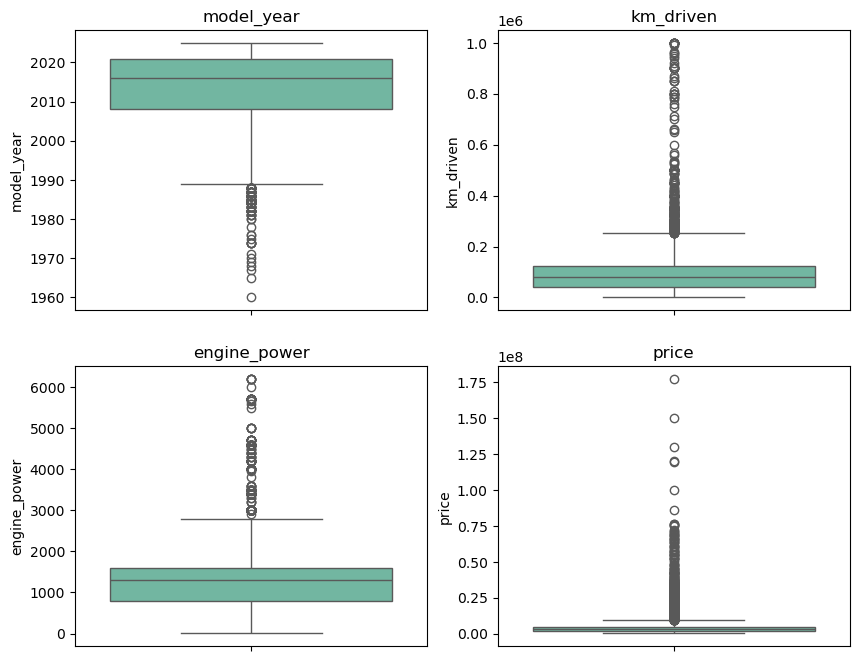

In [105]:
num = ['model_year', 'km_driven', 'engine_power', 'price']

plt.figure(figsize=(10,8))
for i, col in enumerate(num):
    plt.subplot(2, 2, i+1)
    sns.boxplot(data=df[col], palette='Set2')
    plt.title(col)
    
plt.show()

In [101]:
df[df['engine_power']>=7000]

,brand,model_name,province,location,model_year,fuel_type,transmission,km_driven,registered_in,color,assembly,engine_capacity,engine_power,body_type,last_updated,price
314,Suzuki,Suzuki Bolan,Sindh,"Orangi Town, Karachi Sindh",1990.0,Petrol,Manual,6080.0,Karachi,others,Local,7895 cc,7895.0,Hatchback,2025-05-01,650000.0
4828,Suzuki,Suzuki Bolan,Punjab,"Gulrez Housing Scheme, Rawalpindi Punjab",1996.0,Petrol,Manual,1234.0,Islamabad,white,Local,10000 cc,10000.0,Hatchback,2025-04-24,700000.0
6742,Suzuki,Suzuki Alto,KPK,"Azam Town, Abbottabad KPK",2024.0,Petrol,Manual,13000.0,Islamabad,white,Imported,11136 cc,11136.0,Hatchback,2025-05-03,2780000.0


There are 3 cars that engine_power is wrong, suzuki bolan == 800 and suzuki alto == 660

In [102]:
df.loc[(df['model_name'] == 'Suzuki Bolan') & (df['engine_power'] == 7895), 'engine_power'] = 800
df.loc[(df['model_name'] == 'Suzuki Bolan') & (df['engine_power'] == 10000), 'engine_power'] = 800
df.loc[(df['model_name'] == 'Suzuki Alto') & (df['engine_power'] == 11136), 'engine_power'] = 660

In [103]:
df[df['price'] >= 100000000]

,brand,model_name,province,location,model_year,fuel_type,transmission,km_driven,registered_in,color,assembly,engine_capacity,engine_power,body_type,last_updated,price
2967,Lexus,Lexus LX Series LX 600 Ultra Luxury,Punjab,"DHA Phase 7, Lahore Punjab",2023.0,Petrol,Automatic,500.0,Un-Registered,black,Imported,3500 cc,3500.0,SUV,2025-04-20,129900000.0
3238,Lexus,Lexus LX Series LX 600 Ultra Luxury,Sindh,"P.E.C.H.S, Karachi Sindh",2022.0,Petrol,Automatic,9000.0,Un-Registered,white,Imported,3500 cc,3500.0,SUV,2025-04-16,120000000.0
4021,Mercedes,Mercedes Benz G Class G 63 AMG,Sindh,Karachi Sindh,2020.0,Petrol,Automatic,11111.0,Un-Registered,white,Imported,4000 cc,4000.0,SUV,2025-04-18,177500000.0
4651,Haval,Haval H6 HEV,Punjab,Faisalabad Punjab,2023.0,Hybrid,Automatic,45000.0,Punjab,black,Imported,1500 cc,1500.0,SUV,2025-05-07,128000000.0
8849,Chevrolet,Chevrolet Corvette 2LT Coupe,Islamabad,"E-11, Islamabad Islamabad",2021.0,Petrol,Automatic,693.0,Un-Registered,white,Imported,6200 cc,6200.0,Coupe,2025-05-02,100000000.0
8989,Mercedes,Mercedes Benz G Class G 580 EQ,Punjab,"DHA Defence, Lahore Punjab",2024.0,Electric,Automatic,100.0,Un-Registered,black,Imported,116.0 kWh,116.0,SUV,2025-05-04,119500000.0
9927,BMW,BMW X7 xDrive40i,Punjab,"Jail Road, Lahore Punjab",2023.0,Petrol,Automatic,100.0,Un-Registered,grey,Imported,3000 cc,3000.0,Crossover,2025-04-15,150000000.0


The Havel H6 HEV price is 1.28 crore, so there is a type mistake where the price is 12.8 crore

In [104]:
df.loc[(df['model_name'] == 'Haval H6 HEV') & (df['price'] == 128000000), 'price'] = 12800000

Remaining car prices are correct

So these are valid outliers, so we don't remove them

-------------

## Exploratory Data Analysis

### Univariate Analysis

In [122]:
num = ['model_year', 'km_driven', 'engine_power', 'price']
cat = ['brand', 'province', 'fuel_type',
       'transmission', 'registered_in', 'color', 'assembly',
       'body_type']

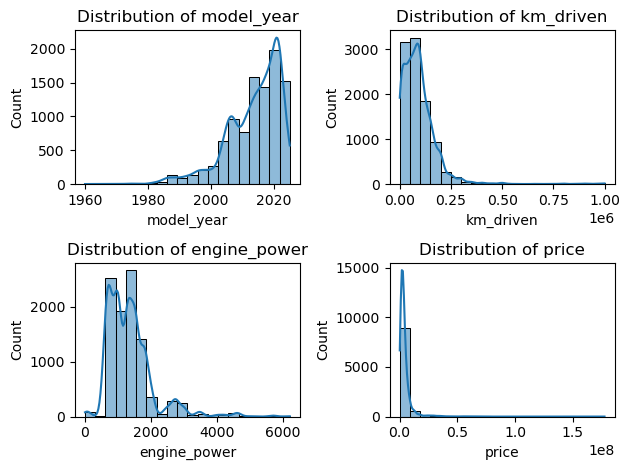

In [110]:
for i, col in enumerate(num):
    plt.subplot(2,2,i+1)
    sns.histplot(data=df, x=col, kde=True, bins=20)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

- Most of the cars model year are btw 2000 to 2025
- From 1 to 250000 km driven cars most in the data
- Most cars have engine power ranging from 600 to 3000 cc, with lower values representing electric vehicles (measured in kWh).
- Price column is highly peaked right skewed

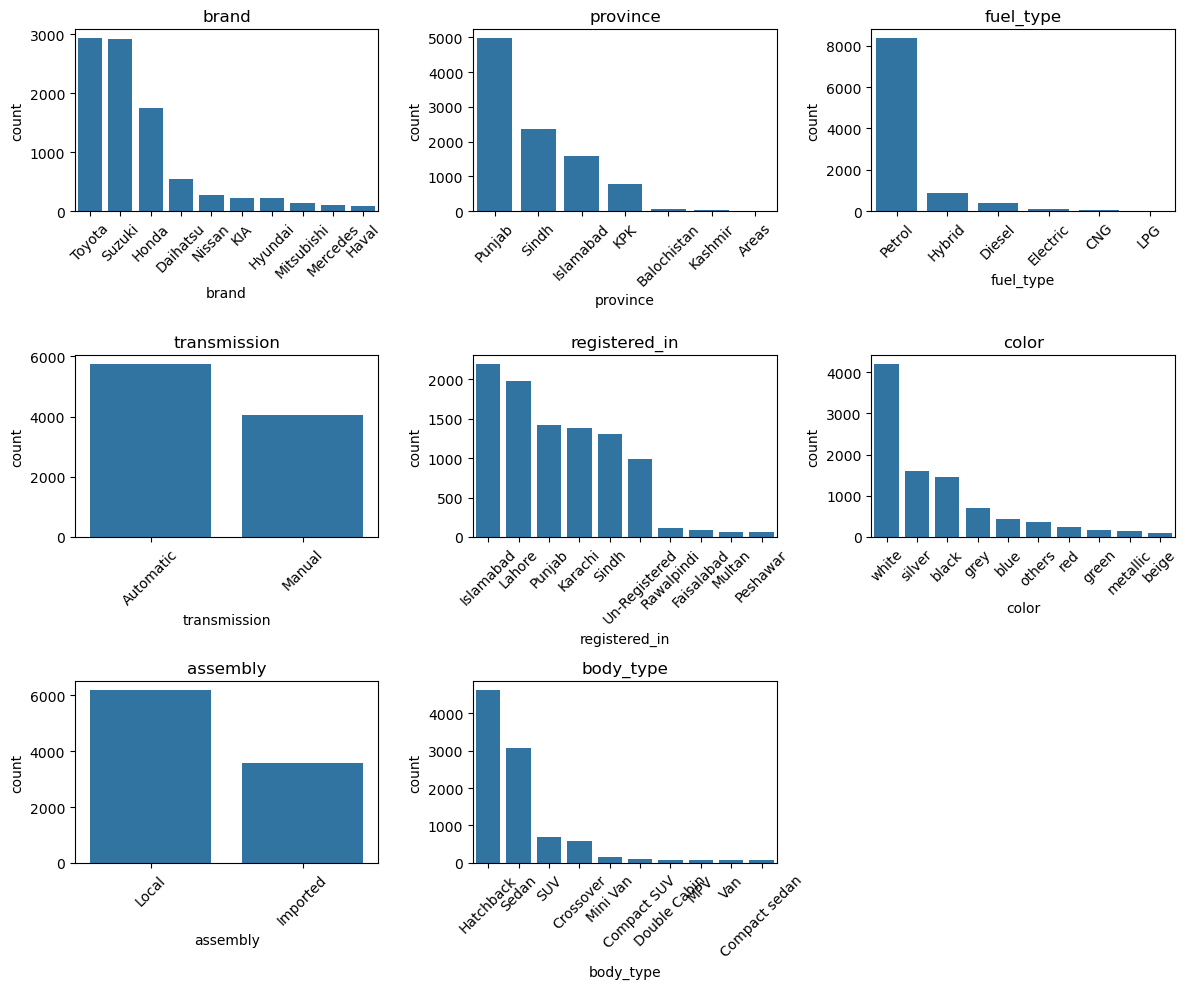

In [129]:
plt.figure(figsize=(12,10))
for i, col in enumerate(cat):
    plt.subplot(3,3,i+1)
    top_10 = df[col].value_counts().nlargest(10).index
    filtered = df[df[col].isin(top_10)]
    sns.countplot(data=filtered, x=col, order=top_10)
    plt.xticks(rotation=45)
    plt.title(f'{col}')

plt.tight_layout()
plt.show()

1. Popular Car Brands
   - Toyota, Suzuki, and Honda dominate the market, indicating strong brand preference and market presence.
2. Regional Distribution
   - A majority of the cars are registered in the provinces of Punjab and Sindh, suggesting higher vehicle ownership in these regions.
3. Fuel Type Preference
   - Petrol-powered vehicles are the most common, reflecting user preference or fuel availability in the market.
4. Transmission Type
   - Automatic transmission vehicles are more prevalent, indicating a shift toward convenience and modern driving preferences.
5. City-wise Registration
   - Most cars are registered in Islamabad, Lahore, and Karachi, which are major urban centers with high vehicle density.
6. Popular Car Colors
   - White is the most popular car color, likely due to its neutral appeal and better heat reflection in warmer climates.
7. Assembly Type
   - The majority of vehicles are locally assembled, highlighting the strength of domestic automotive production.
8. Common Body Types
   - Hatchbacks and Sedans are the most common body types, reflecting their suitability for city driving and family use.



--------

## Bivariate Analaysis

In [130]:
df.head()

,brand,model_name,province,location,model_year,fuel_type,transmission,km_driven,registered_in,color,assembly,engine_capacity,engine_power,body_type,last_updated,price
0,Suzuki,Suzuki Mehran,Punjab,Multan Punjab,2003.0,Petrol,Manual,170000.0,Lahore,white,Local,800 cc,800.0,Hatchback,2025-05-07,580000.0
1,Mitsubishi,Mitsubishi Lancer GLX Automatic 1.6,Punjab,Lahore Punjab,2006.0,Petrol,Automatic,119080.0,Islamabad,black,Imported,1600 cc,1600.0,Sedan,2025-04-29,2500000.0
2,Suzuki,Suzuki Wagon R Stingray X,Punjab,"Abbot Road, Lahore Punjab",2013.0,Petrol,Automatic,87000.0,Punjab,black,Imported,660 cc,660.0,Hatchback,2025-04-29,2650000.0
3,Toyota,Toyota Land Cruiser ZX,Punjab,Lahore Punjab,2019.0,Petrol,Automatic,30000.0,Un-Registered,white,Imported,4600 cc,4600.0,SUV,2025-04-28,46300000.0
4,Suzuki,Suzuki Alto VXL AGS,Punjab,"Rehmania Town, Faisalabad Punjab",2021.0,Petrol,Automatic,15800.0,Punjab,silver,Local,660 cc,660.0,Hatchback,2025-04-30,2770000.0


Brand vs Price

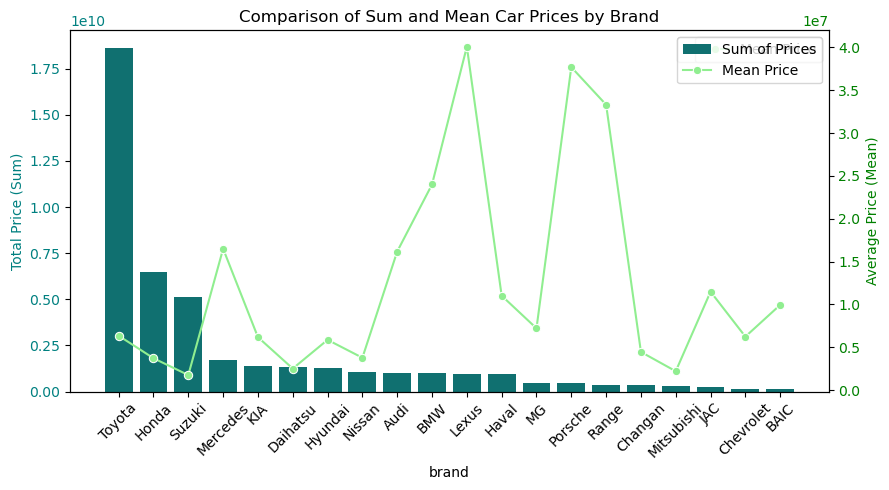

In [149]:
brand_price_stats = df.groupby('brand')['price'].agg(['sum', 'mean']).reset_index()
brand_price_stats = brand_price_stats.sort_values(by='sum', ascending=False).head(20) \

fig, ax1 = plt.subplots(figsize=(9, 5))
sns.barplot(x='brand', y='sum', data=brand_price_stats, ax=ax1, color='teal', label='Sum of Prices')
ax1.set_ylabel('Total Price (Sum)', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

ax2 = ax1.twinx()
sns.lineplot(x='brand', y='mean', data=brand_price_stats, ax=ax2, color='lightgreen', marker='o', label='Mean Price')
ax2.set_ylabel('Average Price (Mean)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Comparison of Sum and Mean Car Prices by Brand')
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.tight_layout()
plt.show()